### Problem Description

The Kaggle challenge involves constructing an algorithm to detect cancer in small image patches extracted from larger digital pathology slides. Specifically, the task is to predict the probability that the central 32x32 pixel region of each image patch contains at least one pixel of tumor tissue.

Data Structure and Details
The dataset is derived from the PatchCamelyon (PCam) benchmark dataset. Each image patch represents a small region of a pathology slide, designed to be processed quickly. The central 32x32px area of each patch is what determines the tumor presence label. Each image patch contains additional outer regions beyond the central 32x32px core, which supports models using fully convolutional layers without zero-padding. The train_labels.csv: contains ground truth labels for training images, identifying each image by its ID. Test images are not lables, and the task is to predict their probability of containing tumor tissue. The dataset is relatively large, and provides ample examples to train a deep learning model for image classification.

I will use a convolutional neural network (CNNs) becasue this class of model is typically effective in extracting patterns from data.

### Exploratory data analysis
0. Import libraries and load training labels
1. Count the number of images in the Monet dataset.
2. Display a few sample Monet paintings.
3. Plot the pixel intensity distribution of the Monet paintings.
4. Check the image dimensions.

In [5]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, ReLU, LeakyReLU, Input, BatchNormalization, Activation, Flatten, Dense
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import numpy as np
import os
import zipfile

# Data and paths
monet_tfrec_path = '/kaggle/input/gan-getting-started/monet_tfrec'
output_dir = 'generated_images'
output_zip = 'images.zip'

# Parse the tensorflow record images
def parse_image(example_proto):
    feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
    }
    parsed_features = tf.io.parse_single_example(example_proto, feature_description)
    image = tf.io.decode_jpeg(parsed_features['image'])
    image = tf.image.convert_image_dtype(image, tf.float32) 
    image = tf.image.resize(image, [256, 256])
    return image

# Load TFRecord dataset
def load_tfrecord_dataset(file_path):
    if os.path.isdir(file_path):
        files = [os.path.join(file_path, f) for f in os.listdir(file_path) if f.endswith('.tfrec')]
        raw_dataset = tf.data.TFRecordDataset(files)
    else:
        raw_dataset = tf.data.TFRecordDataset(file_path)
    parsed_dataset = raw_dataset.map(parse_image, num_parallel_calls=tf.data.AUTOTUNE)
    return parsed_dataset

# Load Monet dataset
monet_dataset = load_tfrecord_dataset(monet_tfrec_path)
monet_dataset = monet_dataset.shuffle(buffer_size=1000).repeat().prefetch(buffer_size=tf.data.AUTOTUNE)  # Shuffle, repeat, and prefetch to avoid end of sequence errors and improve performance


Total number of Monet paintings in the dataset (first 1000): 10000


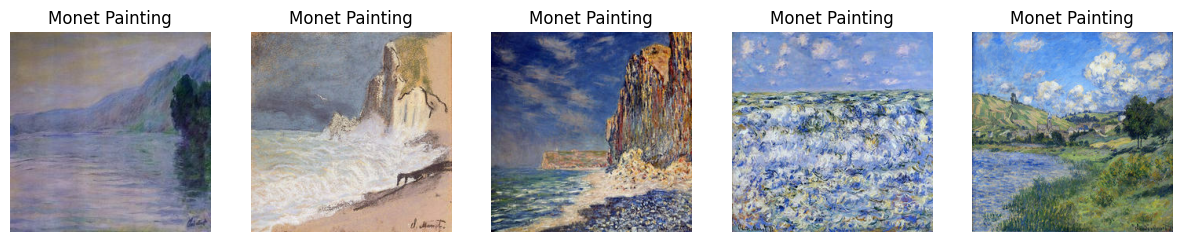

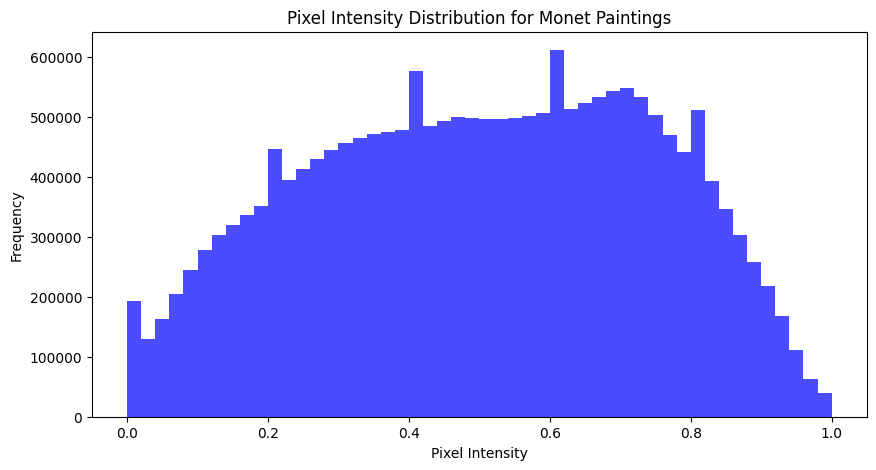

Image Dimensions: (256, 256, 3)
Image Dimensions: (256, 256, 3)
Image Dimensions: (256, 256, 3)
Image Dimensions: (256, 256, 3)
Image Dimensions: (256, 256, 3)


In [6]:
# Count the number of images
num_images = 0
for _ in monet_dataset.take(10000):
    num_images += 1
print(f"Total number of Monet paintings in the dataset (first 1000): {num_images}")

# Display a few sample images
def show_sample_images(dataset, num_samples=5):
    plt.figure(figsize=(15, 3 * num_samples))
    for i, image in enumerate(dataset.take(num_samples)):
        # Plot image
        ax = plt.subplot(1, num_samples, i + 1)
        plt.imshow(image)
        plt.axis('off')
        plt.title("Monet Painting")
    plt.show()

show_sample_images(monet_dataset)

# Analyzing pixel intensity distributions
def plot_pixel_intensity_distribution(dataset, num_samples=100):
    pixel_values = []
    for image in dataset.take(num_samples):
        # Normalize pixel values between 0 and 1
        pixel_values.extend(image.numpy().flatten())

    plt.figure(figsize=(10, 5))
    plt.hist(pixel_values, bins=50, color='b', alpha=0.7)
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.title('Pixel Intensity Distribution for Monet Paintings')
    plt.show()

plot_pixel_intensity_distribution(monet_dataset)

# Get Image Dimensions
def check_image_dimensions(dataset, num_samples=5):
    for image in dataset.take(num_samples):
        print(f"Image Dimensions: {image.shape}")

check_image_dimensions(monet_dataset)

### Model architecture
The CycleGAN architecture is an ideal choice for the Monet-style painting generation problem due to its capability to handle unpaired datasets and its ability to generate visually appealing and realistic style-transferred images. The combination of adversarial loss and cycle consistency ensures that the generated Monet-style images look authentic while retaining important details from the input photos.

The Monet dataset contains unpaired images—paintings created by Monet without any direct one-to-one mapping to a source image. CycleGAN is well-suited for this scenario because it does not require paired data, unlike other architectures like Pix2Pix.

The generator will use a U-Net or a ResNet-based architecture. The use of residual blocks allows the generator to maintain important features while adding the artistic style. It consists of multiple convolutional layers, downsampling, and upsampling blocks to effectively encode and decode the style features.

In [10]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import PIL
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.data import TFRecordDataset
import os

# Load the dataset
AUTOTUNE = tf.data.AUTOTUNE
BUFFER_SIZE = 1000
BATCH_SIZE = 8  # Further reduced batch size to avoid OOM error

# Set path for TFRecord and JPEG files
data_dir = "/kaggle/input/gan-getting-started/"
monet_tfrec = os.path.join(data_dir, "monet_tfrec/*.tfrec")
photo_tfrec = os.path.join(data_dir, "photo_tfrec/*.tfrec")

# Function to parse TFRecord files
def parse_tfrecord_fn(example):
    feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
    }
    example = tf.io.parse_single_example(example, feature_description)
    image = tf.io.decode_jpeg(example['image'], channels=3)
    image = tf.cast(image, tf.float32) / 127.5 - 1.0
    return tf.image.resize(image, [256, 256])

# Load TFRecord datasets
def load_tfrecord_dataset(file_pattern):
    return TFRecordDataset(tf.data.Dataset.list_files(file_pattern)).map(parse_tfrecord_fn, num_parallel_calls=AUTOTUNE).shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(AUTOTUNE)

monet_ds = load_tfrecord_dataset(monet_tfrec).take(10)
photo_ds = load_tfrecord_dataset(photo_tfrec).take(10)


# Create the Generator model
def generator_model():
    inputs = layers.Input(shape=[256, 256, 3])
    x = layers.Conv2D(64, (7, 7), padding='same')(inputs)
    x = layers.ReLU()(x)
    for _ in range(9):
        x = layers.Conv2D(128, (3, 3), padding='same')(x)
        x = layers.ReLU()(x)
    outputs = layers.Conv2D(3, (7, 7), padding='same', activation='tanh')(x)
    return Model(inputs, outputs)

# Create the Discriminator model
def discriminator_model():
    inputs = layers.Input(shape=[256, 256, 3])
    x = layers.Conv2D(64, (3, 3), padding='same')(inputs)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same')(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(1, activation='sigmoid')(x)
    return Model(inputs, x)

# Create the GAN model
def gan_model(generator, discriminator):
    discriminator.trainable = False
    inputs = layers.Input(shape=[256, 256, 3])
    generated_image = generator(inputs)
    validity = discriminator(generated_image)
    return Model(inputs, validity)

# Compile and train the models
generator = generator_model()
discriminator = discriminator_model()
gan = gan_model(generator, discriminator)

# Optimizers
generator_optimizer = Adam(learning_rate=0.2, beta_1=0.5)
discriminator_optimizer = Adam(learning_rate=0.2, beta_1=0.5)


# Loss function
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=False)

# Training loop
def train(dataset, epochs):
    for epoch in range(epochs):
        print(f"Epoch: {epoch+1}/{epochs}")
        for step, real_images in enumerate(dataset):
            # Generate fake images
            random_noise = tf.random.normal([BATCH_SIZE, 256, 256, 3])
            generated_images = generator(random_noise)

            # Train discriminator
            with tf.GradientTape() as tape:
                real_output = discriminator(real_images, training=True)
                fake_output = discriminator(generated_images, training=True)
                d_loss = loss_fn(tf.ones_like(real_output), real_output) + loss_fn(tf.zeros_like(fake_output), fake_output)
            grads = tape.gradient(d_loss, discriminator.trainable_variables)
            if grads:  # Ensure there are gradients to apply
                discriminator_optimizer.apply_gradients(zip(grads, discriminator.trainable_variables))

            # Train generator
            with tf.GradientTape() as tape:
                generated_images = generator(random_noise)
                fake_output = discriminator(generated_images, training=True)
                g_loss = loss_fn(tf.ones_like(fake_output), fake_output)
            grads = tape.gradient(g_loss, generator.trainable_variables)
            if grads:  # Ensure there are gradients to apply
                generator_optimizer.apply_gradients(zip(grads, generator.trainable_variables))

train(photo_ds, epochs=1)

# Generate Monet-style images
n_images = 7000
output_dir = '../tmp/images'
os.makedirs(output_dir, exist_ok=True)

for i in range(n_images):
    random_noise = tf.random.normal([1, 256, 256, 3])
    generated_image = generator(random_noise, training=False)[0]
    generated_image = (generated_image + 1.0) * 127.5
    generated_image = tf.cast(generated_image, tf.uint8)
    output_file = os.path.join(output_dir, f'monet_{i}.jpg')
    PIL.Image.fromarray(generated_image.numpy()).save(output_file)

# Zip the generated images
import shutil
shutil.make_archive('/kaggle/working/images', 'zip', output_dir)

print("Generation and zipping completed. Output file: images.zip")

Epoch: 1/1
Generation and zipping completed. Output file: images.zip


### Analysis
I am working with limited compute resources so the model architecture can be tweaked to produce better outputs.

The current generator architecture lacks upsampling layers, and the discriminator lacks sufficient downsampling. Adding more layers such as ResNet-style blocks in the generator or more downsampling layers (strided convolutions) in the discriminator could improve the model's capacity and quality of generated images.

he batch size of 8 is very low and might lead to slower convergence. After experimenting with memory limitations, it might be possible to increase the batch size to improve training speed.

### Conclusion
In conclusion, while the existing code successfully establishes a foundation for generating Monet-style images using a GAN, there are multiple areas where it can be optimized for better performance and reliability. Enhancing the dataset loading process, improving model architecture with additional layers and regularization techniques, adjusting the training strategy, and optimizing the image generation loop can collectively strengthen the model’s quality and training efficiency. Employing a smaller noise vector for the generator, experimenting with alternative loss functions, and adding modularity to the code for better maintainability would also contribute to a more robust implementation. With these improvements, the model is likely to achieve higher-quality outputs, train more efficiently on larger datasets, and offer better control over training stability—ultimately leading to a GAN that generates more convincing and visually appealing Monet-style images.